<a href="https://colab.research.google.com/github/DavidReveloLuna/MaskRCNN_Video/blob/master/Casco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import json
import numpy as np
import time
from PIL import Image, ImageDraw
import skimage.draw
import random


In [2]:
!git clone https://github.com/DavidReveloLuna/MaskRCNN_Video.git

Cloning into 'MaskRCNN_Video'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 111 (delta 39), reused 59 (delta 8), pack-reused 0
Receiving objects: 100% (111/111), 46.52 MiB | 29.12 MiB/s, done.
Resolving deltas: 100% (39/39), done.


In [3]:
cd MaskRCNN_Video/


D:\10decimoCiclo\Capstone\modelos\MaskRCNN\MaskRCNN_Video


In [4]:
cd D:\10decimoCiclo\Capstone\modelos\MaskRCNN\MaskRCNN_Video

D:\10decimoCiclo\Capstone\modelos\MaskRCNN\MaskRCNN_Video


In [10]:
ROOT_DIR = r'D:\10decimoCiclo\Capstone\modelos\MaskRCNN\MaskRCNN_Video'
assert os.path.exists(ROOT_DIR), 'ROOT_DIR does not exist'

sys.path.append(ROOT_DIR) 

from mrcnn import visualize
from mrcnn.config import Config
from mrcnn import model as modellib, utils

In [18]:
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [19]:
class DienteConfig(Config):
    """Configuration for training on the helmet  dataset.
    """
    # Give the configuration a recognizable name
    NAME = "diente"

    # Train on 1 GPU and 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 (diente)

    # All of our training images are 512x512
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512

    # You can experiment with this number to see if it improves training
    STEPS_PER_EPOCH = 500

    # This is how often validation is run. If you are using too much hard drive space
    # on saved models (in the MODEL_DIR), try making this value larger.
    VALIDATION_STEPS = 5
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # To be honest, I haven't taken the time to figure out what these do
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    TRAIN_ROIS_PER_IMAGE = 32
    MAX_GT_INSTANCES = 50 
    POST_NMS_ROIS_INFERENCE = 500 
    POST_NMS_ROIS_TRAINING = 1000 
    
config = DienteConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE              

In [20]:
class DienteDataset(utils.Dataset):

    def load_dientes(self, dataset_dir, subset):
        """Load a subset of the Diente dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("diente", 1, "diente")

        # Train or validation dataset?
        assert subset in ["dataset", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator (up to version 1.6) saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        # Note: In VIA 2.0, regions was changed from a dict to a list.
        annotations = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        annotations = list(annotations.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. These are stores in the
            # shape_attributes (see json format above)
            # The if condition is needed to support VIA versions 1.x and 2.x.
            if type(a['regions']) is dict:
                polygons = [r['shape_attributes'] for r in a['regions'].values()]
            else:
                polygons = [r['shape_attributes'] for r in a['regions']] 

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "diente",
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a diente dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "diente":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

            # Verificar que las coordenadas no excedan el tamaño de la imagen
            rr = np.clip(rr, 0, mask.shape[0] - 1)
            cc = np.clip(cc, 0, mask.shape[1] - 1)

            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "diente":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [21]:
dataset_train = DienteDataset()
dataset_train.load_dientes(r"D:\10decimoCiclo\Capstone\modelos\MaskRCNN\dataset", "dataset")
dataset_train.prepare()

# Validation dataset
dataset_val = DienteDataset()
dataset_val.load_dientes(r"D:\10decimoCiclo\Capstone\modelos\MaskRCNN\dataset", "val")
dataset_val.prepare()

In [9]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

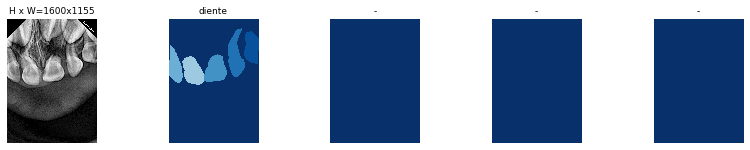

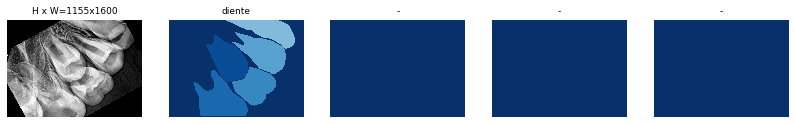

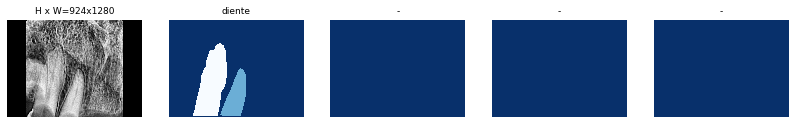

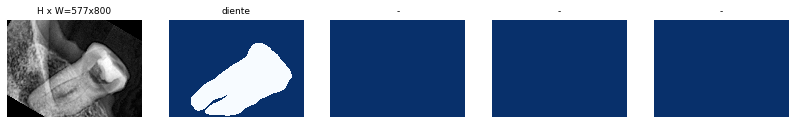

In [11]:
# Load and display random samples
dataset = dataset_train
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  214 D:\10decimoCiclo\Capstone\modelos\MaskRCNN\dataset\dataset\diente_215.jpeg
image                    shape: (1155, 1600, 3)       min:    0.00000  max:  255.00000  uint8
mask                     shape: (1155, 1600, 3)       min:    0.00000  max:    1.00000  bool
class_ids                shape: (3,)                  min:    1.00000  max:    1.00000  int32
bbox                     shape: (3, 4)                min:    4.00000  max: 1155.00000  int32


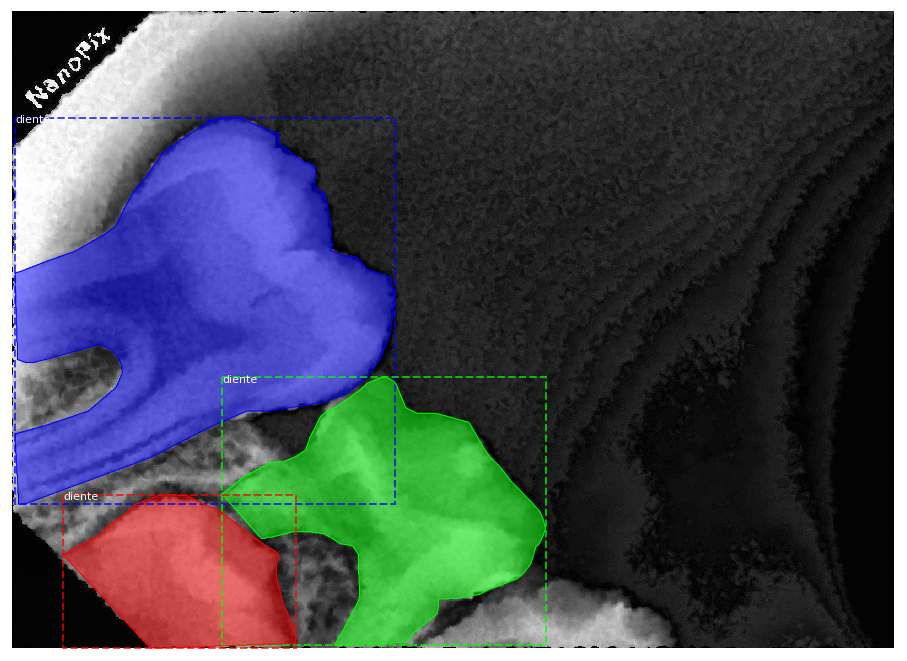

In [12]:
from mrcnn.model import log
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [14]:
model.train(dataset_train, dataset_val, 
            learning_rate=0.001, 
            epochs=600, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/MaskRCNN_Video/logs/casco20200904T1346/mask_rcnn_casco_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv    

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


500/500 [==============================] - ETA: 0s - batch: 249.5000 - size: 1.0000 - loss: 1.0458 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.4837 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.2724 - mrcnn_mask_loss: 0.2024WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
500/500 [==============================] - 106s 211ms/step - batch: 249.5000 - size: 1.0000 - loss: 1.0458 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.4837 - mrcnn_class_loss: 0.0719 - mrcnn_bbox_loss: 0.2724 - mrcnn_mask_loss: 0.2024 - val_loss: 1.4291 - val_rpn_class_loss: 0.0053 - val_rpn_bbox_loss: 0.5716 - val_mrcnn_class_loss: 0.1348 - val_mrcnn_bbox_loss: 0.3559 - val_mrcnn_mask_loss: 0.3615
Epoch 2/10
500/500

In [23]:
class InferenceConfig(CascoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #IMAGE_MIN_DIM = 512
    #IMAGE_MAX_DIM = 512
    #DETECTION_MIN_CONFIDENCE = 0.85
    

inference_config = InferenceConfig()

In [24]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config,  model_dir=MODEL_DIR)

In [25]:
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  mask_rcnn_diente_0293.h5


Processing 1 images
image                    shape: (1024, 739, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


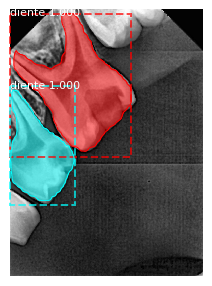

Processing 1 images
image                    shape: (739, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


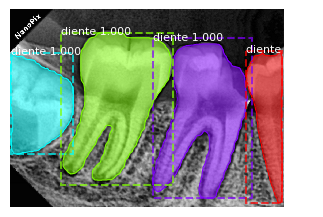

In [33]:
import skimage
import numpy as np
import os
from mrcnn import utils

real_test_dir = r"D:\10decimoCiclo\Capstone\TecnicasProcesamientoDeImagenes\radiografiasMejoradas\val"
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    
    # Check if the image is grayscale (2D) and convert to RGB if necessary
    if len(img.shape) == 2:
        img = skimage.color.gray2rgb(img)
    
    # Ensure the image has 3 channels (RGB)
    if img.shape[2] != 3:
        img = img[:, :, :3]
    
    img_arr = np.array(img)
    
    # Resize the image if it's too large
    max_dim = 1024  # You can adjust this value based on your model's requirements
    scale = max_dim / max(img_arr.shape[:2])
    if scale < 1:
        img_arr = skimage.transform.resize(img_arr, (round(img_arr.shape[0] * scale), round(img_arr.shape[1] * scale)), 
                                           order=1, preserve_range=True)
    
    # Ensure the image is in uint8 format
    img_arr = img_arr.astype(np.uint8)
    
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img_arr, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], figsize=(5,5))

In [34]:
import skimage
import numpy as np
import os
from mrcnn import utils
import cv2

# Directorio con las radiografías
real_test_dir = r"D:\10decimoCiclo\Capstone\modelos\PruebaU-net\Semantic-Segmentation-Basic-U-Net\radiografias"
output_dir = r"DientesSegmentados"  # Carpeta donde guardar las imágenes segmentadas

# Crear carpeta de salida si no existe
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Procesar cada imagen en el directorio
image_paths = [os.path.join(real_test_dir, f) for f in os.listdir(real_test_dir) if os.path.splitext(f)[1].lower() in ['.png', '.jpg', '.jpeg']]

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    
    # Convertir a RGB si es una imagen en escala de grises
    if len(img.shape) == 2:
        img = skimage.color.gray2rgb(img)
    
    # Asegurar que la imagen tenga 3 canales
    if img.shape[2] != 3:
        img = img[:, :, :3]
    
    img_arr = np.array(img)
    
    # Redimensionar si es muy grande
    max_dim = 1024
    scale = max_dim / max(img_arr.shape[:2])
    if scale < 1:
        img_arr = skimage.transform.resize(img_arr, (round(img_arr.shape[0] * scale), round(img_arr.shape[1] * scale)), 
                                           order=1, preserve_range=True)
    
    img_arr = img_arr.astype(np.uint8)
    
    # Detectar usando el modelo Mask R-CNN
    results = model.detect([img_arr], verbose=1)
    r = results[0]

    # Obtener las máscaras y ROIs de la predicción
    masks = r['masks']  # (alto, ancho, N) donde N es el número de objetos detectados
    rois = r['rois']    # (N, 4) con las coordenadas [y1, x1, y2, x2] de cada ROI
    
    num_teeth = masks.shape[-1]  # Número de dientes segmentados

    for i in range(num_teeth):
        # Obtener la máscara del diente i
        mask = masks[:, :, i]
        
        # Obtener las coordenadas de la ROI
        y1, x1, y2, x2 = rois[i]
        
        # Extraer la región de la imagen original
        tooth_image = img_arr[y1:y2, x1:x2]
        
        # Aplicar la máscara sobre la región del diente
        masked_tooth = tooth_image * np.expand_dims(mask[y1:y2, x1:x2], axis=-1)
        
        # Convertir la región segmentada a escala de grises
        gray_masked_tooth = cv2.cvtColor(masked_tooth, cv2.COLOR_BGR2GRAY)
        
        # Guardar la imagen individual del diente
        output_path = os.path.join(output_dir, f'{os.path.basename(image_path)[:-4]}_diente_{i+1}.png')
        cv2.imwrite(output_path, gray_masked_tooth)

        print(f'Guardada la imagen segmentada del diente {i+1}: {output_path}')


Processing 1 images
image                    shape: (1024, 739, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
Guardada la imagen segmentada del diente 1: DientesPruebaFunciono\diente39._diente_1.png
Guardada la imagen segmentada del diente 2: DientesPruebaFunciono\diente39._diente_2.png
Processing 1 images
image                    shape: (739, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
Guardada la imagen

In [14]:
import os

# Mostrar la ruta de la carpeta actual
current_directory = os.getcwd()
print(f"Estás en la carpeta: {current_directory}")


Estás en la carpeta: D:\10decimoCiclo\Capstone\modelos\MaskRCNN\MaskRCNN_Video


In [32]:
import numpy as np
import skimage
import os
import cv2
import mrcnn.config
from mrcnn import model as modellib, utils


def calculate_metrics(ground_truth, prediction):
    """
    Calcula el Coeiciente de Jaccard (IoU) y el Coeficiente Dice.
    
    :param ground_truth: Máscara de verdad terreno (ground truth)
    :param prediction: Máscara predicha por el modelo
    :return: (jaccard, dice)
    """
    intersection = np.logical_and(ground_truth, prediction)
    union = np.logical_or(ground_truth, prediction)
    
    jaccard = np.sum(intersection) / np.sum(union)
    
    dice = 2 * np.sum(intersection) / (np.sum(ground_truth) + np.sum(prediction))
    
    return jaccard, dice

def evaluate_model(model, dataset_val, image_paths):
    jaccard_scores = []
    dice_scores = []
    
    for image_path in image_paths:
        # Cargar y preprocesar la imagen
        img = skimage.io.imread(image_path)
        if len(img.shape) == 2:
            img = skimage.color.gray2rgb(img)
        if img.shape[2] != 3:
            img = img[:, :, :3]
        img_arr = np.array(img).astype(np.uint8)
        
        # Realizar la detección
        results = model.detect([img_arr], verbose=0)
        r = results[0]
        
        # Obtener la máscara de verdad terreno (ground truth)
        # Nota: Debes adaptar esta parte según cómo estén organizadas tus máscaras de ground truth
        gt_mask_path = image_path.replace('images', 'masks').replace('.jpg', '_mask.png')
        gt_mask = cv2.imread(gt_mask_path, cv2.IMREAD_GRAYSCALE) > 0
        
        # Combinar todas las máscaras predichas en una sola
        predicted_mask = np.any(r['masks'], axis=2)
        
        # Asegurar que las máscaras tengan las mismas dimensiones
        if gt_mask.shape != predicted_mask.shape:
            gt_mask = cv2.resize(gt_mask.astype(np.uint8), (predicted_mask.shape[1], predicted_mask.shape[0]), interpolation=cv2.INTER_NEAREST)
            gt_mask = gt_mask > 0
        
        # Calcular métricas
        jaccard, dice = calculate_metrics(gt_mask, predicted_mask)
        jaccard_scores.append(jaccard)
        dice_scores.append(dice)
        
        print(f"Processed {os.path.basename(image_path)}: Jaccard = {jaccard:.4f}, Dice = {dice:.4f}")
    
    # Calcular promedios
    avg_jaccard = np.mean(jaccard_scores)
    avg_dice = np.mean(dice_scores)
    
    print(f"\nEvaluación completa:")
    print(f"Promedio Jaccard (IoU): {avg_jaccard:.4f}")
    print(f"Promedio Dice: {avg_dice:.4f}")
    
    return avg_jaccard, avg_dice

# Uso de la función de evaluación
real_test_dir = r"D:\10decimoCiclo\Capstone\TecnicasProcesamientoDeImagenes\radiografiasMejoradas\val"
image_paths = [os.path.join(real_test_dir, f) for f in os.listdir(real_test_dir) 
               if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

avg_jaccard, avg_dice = evaluate_model(model, dataset_val, image_paths)

Processed diente41.jpeg: Jaccard = 0.1759, Dice = 0.2991
Processed diente42.jpeg: Jaccard = 0.5625, Dice = 0.7200
Processed diente43.jpeg: Jaccard = 0.4446, Dice = 0.6156
Processed diente44.jpeg: Jaccard = 0.4659, Dice = 0.6356
Processed diente45.jpeg: Jaccard = 0.4742, Dice = 0.6434
Processed diente46.jpeg: Jaccard = 0.5282, Dice = 0.6912
Processed diente47.jpeg: Jaccard = 0.3874, Dice = 0.5584
Processed diente48.jpeg: Jaccard = 0.5887, Dice = 0.7411
Processed diente49.jpeg: Jaccard = 0.4773, Dice = 0.6461
Processed diente50.jpeg: Jaccard = 0.4606, Dice = 0.6307
Processed diente51.jpeg: Jaccard = 0.5207, Dice = 0.6848
Processed diente52.jpeg: Jaccard = 0.5015, Dice = 0.6680
Processed diente53.jpeg: Jaccard = 0.6473, Dice = 0.7859
Processed diente54.jpeg: Jaccard = 0.4319, Dice = 0.6032
Processed diente55.jpeg: Jaccard = 0.3886, Dice = 0.5597
Processed diente56.jpeg: Jaccard = 0.4032, Dice = 0.5747
Processed diente57.jpeg: Jaccard = 0.3660, Dice = 0.5359
Processed diente58.jpeg: Jaccar

In [30]:
import skimage
import numpy as np
import os
import json
from skimage.draw import polygon
from mrcnn import utils
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

real_test_dir = r"D:\10decimoCiclo\Capstone\TecnicasProcesamientoDeImagenes\radiografiasMejoradas\val"
json_file_path = r"D:\10decimoCiclo\Capstone\TecnicasProcesamientoDeImagenes\radiografiasMejoradas\val\via_region_data.json"  # Ruta del archivo JSON que contiene todas las máscaras

# Cargar el archivo JSON con la información de todas las imágenes
with open(json_file_path, 'r') as f:
    json_data = json.load(f)

image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

# Función para cargar la máscara desde el archivo JSON basado en el campo "filename"
def load_mask_from_json(image_filename, json_data, image_shape):
    # Buscar la información de la imagen en el JSON usando el campo "filename"
    matching_key = None
    for key, value in json_data.items():
        if value['filename'] == image_filename:
            matching_key = key
            break
    
    if not matching_key:
        raise ValueError(f"No se encontró la información de {image_filename} en el archivo JSON.")

    image_info = json_data[matching_key]
    mask = np.zeros(image_shape[:2], dtype=np.uint8)

    # Crear la máscara a partir de las coordenadas en el archivo JSON
    for region in image_info['regions'].values():
        x_points = region['shape_attributes']['all_points_x']
        y_points = region['shape_attributes']['all_points_y']

        # Recortar los puntos que excedan el tamaño de la imagen
        x_points = np.clip(x_points, 0, image_shape[1] - 1)
        y_points = np.clip(y_points, 0, image_shape[0] - 1)
        
        rr, cc = polygon(y_points, x_points)
        mask[rr, cc] = 1
    
    return mask

# Función para calcular métricas
def evaluate_model(model, image_paths, json_data, threshold=0.5):
    precisions = []
    recalls = []
    f1_scores = []
    aucs = []

    for i, image_path in enumerate(image_paths):
        image_filename = os.path.basename(image_path)  # Nombre del archivo de imagen
        img = skimage.io.imread(image_path)
        
        # Check if the image is grayscale (2D) and convert to RGB if necessary
        if len(img.shape) == 2:
            img = skimage.color.gray2rgb(img)
        
        # Ensure the image has 3 channels (RGB)
        if img.shape[2] != 3:
            img = img[:, :, :3]
        
        img_arr = np.array(img)
        
        # Resize the image if it's too large
        max_dim = 1024  # Puedes ajustar este valor según los requisitos de tu modelo
        scale = max_dim / max(img_arr.shape[:2])
        if scale < 1:
            img_arr = skimage.transform.resize(img_arr, (round(img_arr.shape[0] * scale), round(img_arr.shape[1] * scale)), 
                                               order=1, preserve_range=True)
        
        # Ensure the image is in uint8 format
        img_arr = img_arr.astype(np.uint8)

        # Detect with the model
        results = model.detect([img_arr], verbose=1)
        r = results[0]
        pred_mask = (r['masks'] > threshold).astype(np.uint8)  # Binarize predicted mask

        # Load the ground truth mask from the JSON data for the current image
        true_mask = load_mask_from_json(image_filename, json_data, img_arr.shape)

        # Flatten masks to calculate metrics
        true_mask_flat = true_mask.flatten()
        pred_mask_flat = np.any(pred_mask, axis=-1).flatten()  # Convert multi-channel mask to binary

        # Calculate metrics
        precision = precision_score(true_mask_flat, pred_mask_flat)
        recall = recall_score(true_mask_flat, pred_mask_flat)
        f1 = f1_score(true_mask_flat, pred_mask_flat)
        auc = roc_auc_score(true_mask_flat, pred_mask_flat)

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
        aucs.append(auc)
        
        # Opcional: Imprimir métricas por cada imagen
        print(f"Imagen {i+1}: Precision={precision:.4f}, Recall={recall:.4f}, F1-Score={f1:.4f}, AUC={auc:.4f}")

    # Calcular los promedios
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    mean_f1 = np.mean(f1_scores)
    mean_auc = np.mean(aucs)

    print("\nPromedio de Métricas en el Conjunto de Evaluación:")
    print(f"Precision Promedio: {mean_precision:.4f}")
    print(f"Recall Promedio: {mean_recall:.4f}")
    print(f"F1-Score Promedio: {mean_f1:.4f}")
    print(f"AUC Promedio: {mean_auc:.4f}")

    return mean_precision, mean_recall, mean_f1, mean_auc

# Ejecutar la evaluación
mean_precision, mean_recall, mean_f1, mean_auc = evaluate_model(model, image_paths, json_data)

Processing 1 images
image                    shape: (739, 1024, 3)        min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
Imagen 1: Precision=0.8682, Recall=0.4786, F1-Score=0.6170, AUC=0.7224
Processing 1 images
image                    shape: (739, 1024, 3)        min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
Imagen 2: Precision=0.8657, Recall=0.6791, F1-Score=0.7611, AUC=0.7087
Processing 1 images
image                    shape: (7

Imagen 18: Precision=0.8003, Recall=0.5738, F1-Score=0.6683, AUC=0.6665
Processing 1 images
image                    shape: (739, 1024, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
Imagen 19: Precision=0.7716, Recall=0.5853, F1-Score=0.6657, AUC=0.6850
Processing 1 images
image                    shape: (739, 1024, 3)        min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32
Imagen 20: Precision=0.7484, Recall=0.7572, F1-Score